In [2]:
import numpy as np
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# 读取数据
df = pd.read_csv('train-data.csv', index_col='Unnamed: 0')
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# 查看数据基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


In [5]:
# 查看各列数据类型
df.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

In [6]:
df = df.drop(['New_Price','Location'],axis=1)   #删除新车价格New_Price和销售地点Location两列
df = df.dropna()   #删除有空值的行

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5975 non-null   object 
 1   Year               5975 non-null   int64  
 2   Kilometers_Driven  5975 non-null   int64  
 3   Fuel_Type          5975 non-null   object 
 4   Transmission       5975 non-null   object 
 5   Owner_Type         5975 non-null   object 
 6   Mileage            5975 non-null   object 
 7   Engine             5975 non-null   object 
 8   Power              5975 non-null   object 
 9   Seats              5975 non-null   float64
 10  Price              5975 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 560.2+ KB


In [8]:
#统一标准里程Mileage列的单位为kmpl
df['Mileage'] = df['Mileage'].astype(str).apply(lambda x:float(x.split(' ')[0]) if 'kmpl'in x else float(x.split(' ')[0])*0.725)
#将价格Price列的单位由十万印度卢比换算成人民币万元
df['Price'] = df['Price'].apply(lambda x:round(x*0.842,2))
#处理排量Engine为数值型
df['Engine'] = df['Engine'].astype(str).apply(lambda x:float(x.replace('CC','')))
#处理最大功率Power为数值型
df['Power'] = df['Power'].astype(str).apply(lambda x: np.NAN if x == 'null bhp' else float(x.split(' ')[0]))
df['Power'] = df['Power'].fillna(df['Power'].mean())   #用均值填充最大功率列的缺失值
#处理第几手Owner_Type为数值型
Owner_Type_dict = {'First':1,'Second':2,'Third':3,'Fourth & Above':4}
df['Owner_Type'] = df['Owner_Type'].apply(lambda x:Owner_Type_dict[x])
#处理传动装置类型Transmission为数值型
df['Transmission'] = df['Transmission'].apply(lambda x:1 if x == 'Automatic' else 0)   #自动挡为1，手动挡为0
#处理燃料类型Fuel_Type为数值型
df['Fuel_Type'] = df['Fuel_Type'].apply(lambda x:1 if x == 'Diesel' else 0)   #电动为1，其他为0
df.head()

,Name,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,2010,72000,0,0,1,19.285,998.0,58.16,5.0,1.47
1,Hyundai Creta 1.6 CRDi SX Option,2015,41000,1,0,1,19.670,1582.0,126.20,5.0,10.53
2,Honda Jazz V,2011,46000,0,0,1,18.200,1199.0,88.70,5.0,3.79
3,Maruti Ertiga VDI,2012,87000,1,0,1,20.770,1248.0,88.76,7.0,5.05
4,Audi A4 New 2.0 TDI Multitronic,2013,40670,1,1,2,15.200,1968.0,140.80,5.0,14.94


In [9]:
df['Name'] = df['Name'].astype(str).apply(lambda x:x.split(' ')[0])   #只保留汽车的品牌信息
df_name = df.groupby('Name').agg({'Price':'mean'}).sort_values('Price')
df_name.head()

,Price
Name,
Ambassador,1.140000
Smart,2.530000
Chevrolet,2.563140
Datsun,2.567692
Fiat,2.812400


In [10]:
df_name_dict = {}
df_name_dict_reversal = {}
n = 1
for i in df_name.index:
    df_name_dict[i] = n
    df_name_dict_reversal[n] = i
    n += 1
df['Name'] = df['Name'].astype(str).apply(lambda x:df_name_dict[x])
df.head()

,Name,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,7,2010,72000,0,0,1,19.285,998.0,58.16,5.0,1.47
1,10,2015,41000,1,0,1,19.670,1582.0,126.20,5.0,10.53
2,11,2011,46000,0,0,1,18.200,1199.0,88.70,5.0,3.79
3,7,2012,87000,1,0,1,20.770,1248.0,88.76,7.0,5.05
4,24,2013,40670,1,1,2,15.200,1968.0,140.80,5.0,14.94


In [11]:
df.dtypes

Name                   int64
Year                   int64
Kilometers_Driven      int64
Fuel_Type              int64
Transmission           int64
Owner_Type             int64
Mileage              float64
Engine               float64
Power                float64
Seats                float64
Price                float64
dtype: object

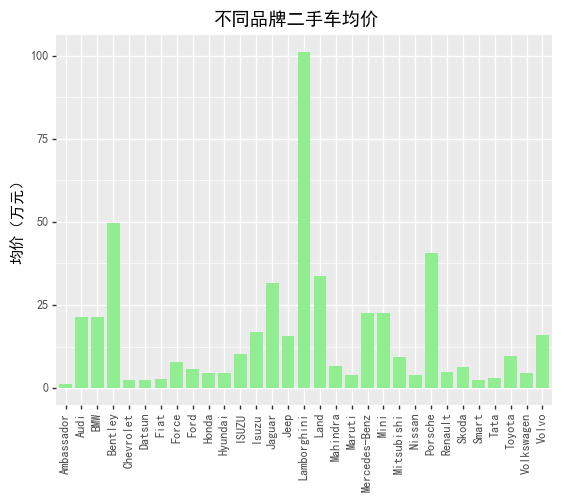

<ggplot: (120849820832)>

In [12]:
df1 = pd.DataFrame(df.groupby('Name')['Price'].mean()).reset_index()
def return_key(val):
    for key, value in df_name_dict.items():
        if value==val:
            return key
df1['Name']= df1['Name'].apply(lambda x:return_key(x))
(
    ggplot(df1, aes('Name', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + theme(axis_text_x = element_text(angle = 90)) 
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同品牌二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

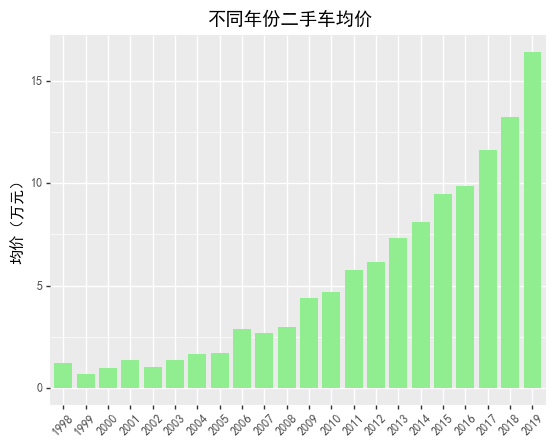

<ggplot: (120850364121)>

In [13]:
df2 = pd.DataFrame(df.groupby('Year')['Price'].mean()).reset_index()
(
    ggplot(df2, aes('factor(Year)', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + theme(axis_text_x = element_text(angle = 45)) 
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同年份二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24812\2623418715.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


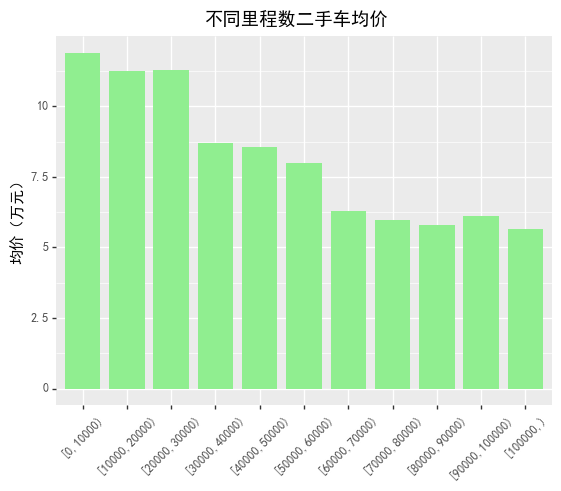

<ggplot: (120850424748)>

In [14]:
df3 = df[['Kilometers_Driven','Price']]
for i in df3.index:
    if df3.at[i,'Kilometers_Driven']>=0 and df3.at[i,'Kilometers_Driven']<10000:
        df3.at[i,'Kilometers'] = '[0,10000)'
    elif df3.at[i,'Kilometers_Driven']>=10000 and df3.at[i,'Kilometers_Driven']<20000:
        df3.at[i,'Kilometers'] = '[10000,20000)'
    elif df3.at[i,'Kilometers_Driven']>=20000 and df3.at[i,'Kilometers_Driven']<30000:
        df3.at[i,'Kilometers'] = '[20000,30000)'
    elif df3.at[i,'Kilometers_Driven']>=30000 and df3.at[i,'Kilometers_Driven']<40000:
        df3.at[i,'Kilometers'] = '[30000,40000)'
    elif df3.at[i,'Kilometers_Driven']>=40000 and df3.at[i,'Kilometers_Driven']<50000:
        df3.at[i,'Kilometers'] = '[40000,50000)'
    elif df3.at[i,'Kilometers_Driven']>=50000 and df3.at[i,'Kilometers_Driven']<60000:
        df3.at[i,'Kilometers'] = '[50000,60000)'
    elif df3.at[i,'Kilometers_Driven']>=60000 and df3.at[i,'Kilometers_Driven']<70000:
        df3.at[i,'Kilometers'] = '[60000,70000)'
    elif df3.at[i,'Kilometers_Driven']>=70000 and df3.at[i,'Kilometers_Driven']<80000:
        df3.at[i,'Kilometers'] = '[70000,80000)'
    elif df3.at[i,'Kilometers_Driven']>=80000 and df3.at[i,'Kilometers_Driven']<90000:
        df3.at[i,'Kilometers'] = '[80000,90000)'
    elif df3.at[i,'Kilometers_Driven']>=90000 and df3.at[i,'Kilometers_Driven']<100000:
        df3.at[i,'Kilometers'] = '[90000,100000)'
    elif df3.at[i,'Kilometers_Driven']>=100000:
        df3.at[i,'Kilometers'] = '[100000,)'

df3 = pd.DataFrame(df3.groupby('Kilometers')['Price'].mean()).reset_index()
(
    ggplot(df3, aes('Kilometers', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + theme(axis_text_x = element_text(angle = 45)) 
    + scale_x_discrete(limits=('[0,10000)','[10000,20000)','[20000,30000)','[30000,40000)','[40000,50000)','[50000,60000)','[60000,70000)','[70000,80000)','[80000,90000)','[90000,100000)','[100000,)'))
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同里程数二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

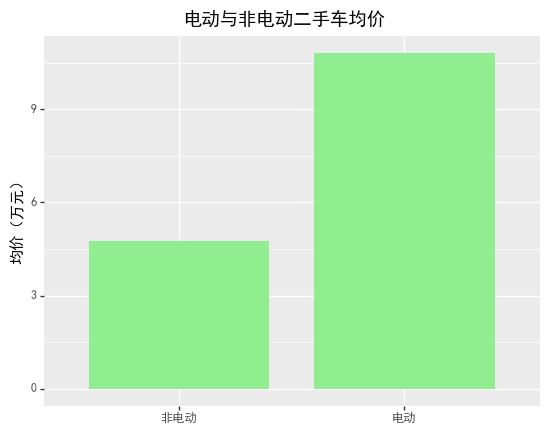

<ggplot: (120849862048)>

In [15]:
df4 = pd.DataFrame(df.groupby('Fuel_Type')['Price'].mean()).reset_index()
(
    ggplot(df4, aes('factor(Fuel_Type)', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + scale_x_discrete(labels=('非电动','电动'))
    + theme(text=element_text(family=['SimHei']))
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('电动与非电动二手车均价')
)

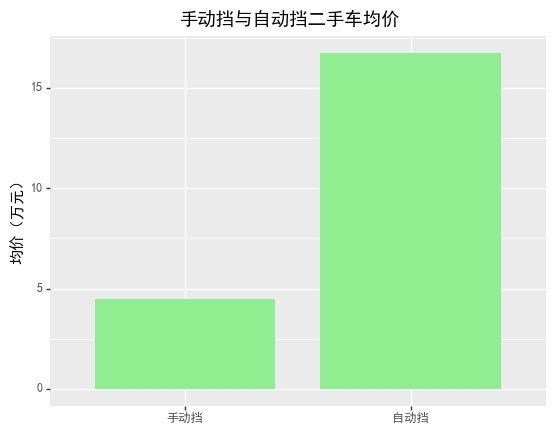

<ggplot: (120850608225)>

In [16]:
df5 = pd.DataFrame(df.groupby('Transmission')['Price'].mean()).reset_index()
(
    ggplot(df5, aes('factor(Transmission)', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + scale_x_discrete(labels=('手动挡','自动挡'))
    + theme(text=element_text(family=['SimHei']))
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('手动挡与自动挡二手车均价')
)

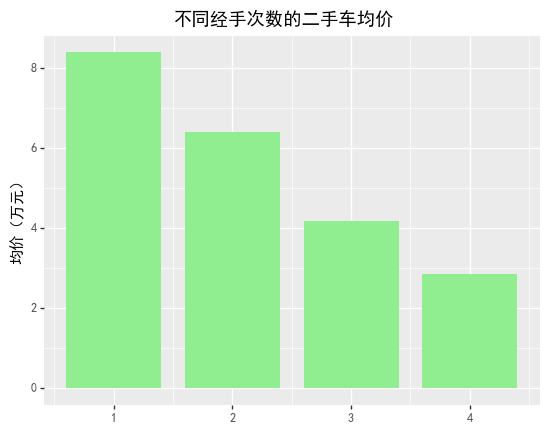

<ggplot: (120850419008)>

In [17]:
df6 = pd.DataFrame(df.groupby('Owner_Type')['Price'].mean()).reset_index()
(
    ggplot(df6, aes('Owner_Type', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同经手次数的二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24812\3078838066.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


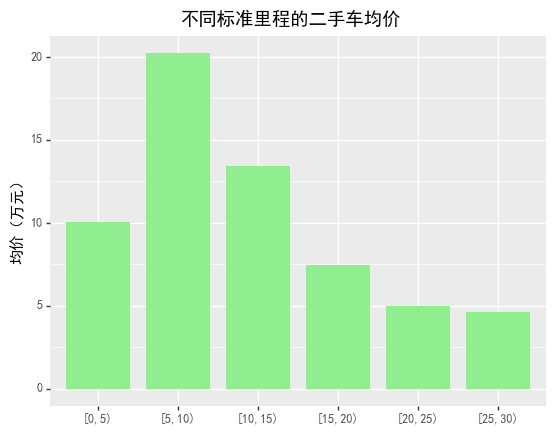

<ggplot: (120849675427)>

In [18]:
df7 = df[['Mileage','Price']]
for i in df7.index:
    if df7.at[i,'Mileage']>=0 and df7.at[i,'Mileage']<5:
        df7.at[i,'Mileage_level'] = '[0,5)'
    elif df7.at[i,'Mileage']>=5 and df7.at[i,'Mileage']<10:
        df7.at[i,'Mileage_level'] = '[5,10)'
    elif df7.at[i,'Mileage']>=10 and df7.at[i,'Mileage']<15:
        df7.at[i,'Mileage_level'] = '[10,15)'
    elif df7.at[i,'Mileage']>=15 and df7.at[i,'Mileage']<20:
        df7.at[i,'Mileage_level'] = '[15,20)'
    elif df7.at[i,'Mileage']>=20 and df7.at[i,'Mileage']<25:
        df7.at[i,'Mileage_level'] = '[20,25)'
    elif df7.at[i,'Mileage']>=25 and df7.at[i,'Mileage']<30:
        df7.at[i,'Mileage_level'] = '[25,30)'

df7 = pd.DataFrame(df7.groupby('Mileage_level')['Price'].mean()).reset_index()
(
    ggplot(df7, aes('Mileage_level', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen') 
    + scale_x_discrete(limits=('[0,5)','[5,10)','[10,15)','[15,20)','[20,25)','[25,30)')) 
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同标准里程的二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24812\785520287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


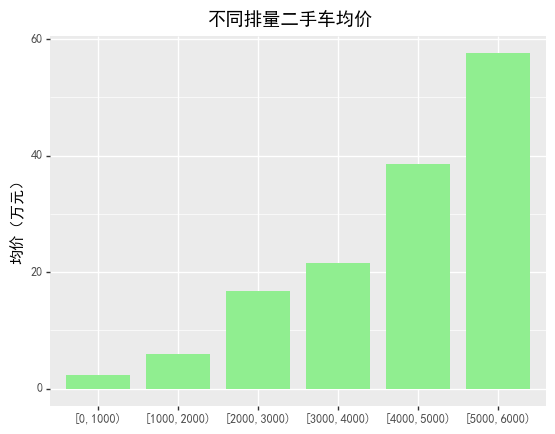

<ggplot: (120850815729)>

In [19]:
df8 = df[['Engine','Price']]
for i in df8.index:
    if df8.at[i,'Engine']>=0 and df8.at[i,'Engine']<1000:
        df8.at[i,'Engine_level'] = '[0,1000)'
    elif df8.at[i,'Engine']>=1000 and df8.at[i,'Engine']<2000:
        df8.at[i,'Engine_level'] = '[1000,2000)'
    elif df8.at[i,'Engine']>=2000 and df8.at[i,'Engine']<3000:
        df8.at[i,'Engine_level'] = '[2000,3000)'
    elif df8.at[i,'Engine']>=3000 and df8.at[i,'Engine']<4000:
        df8.at[i,'Engine_level'] = '[3000,4000)'
    elif df8.at[i,'Engine']>=4000 and df8.at[i,'Engine']<5000:
        df8.at[i,'Engine_level'] = '[4000,5000)'
    elif df8.at[i,'Engine']>=5000 and df8.at[i,'Engine']<6000:
        df8.at[i,'Engine_level'] = '[5000,6000)'

df8 = pd.DataFrame(df8.groupby('Engine_level')['Price'].mean()).reset_index()
(
    ggplot(df8, aes('Engine_level', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + scale_x_discrete(limits=('[0,1000)','[1000,2000)','[2000,3000)','[3000,4000)','[4000,5000)','[5000,6000)')) 
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同排量二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24812\2288422568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


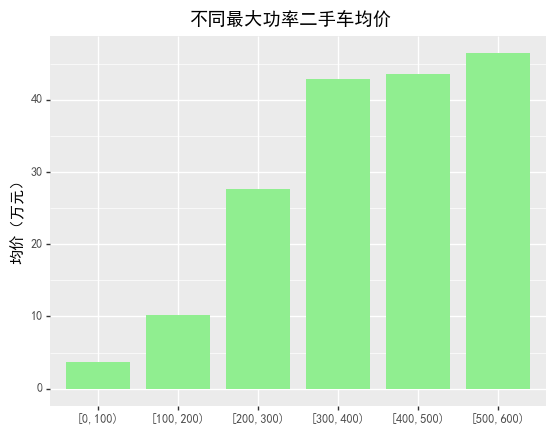

<ggplot: (120850849789)>

In [20]:
df9 = df[['Power','Price']]
for i in df9.index:
    if df9.at[i,'Power']>=0 and df9.at[i,'Power']<100:
        df9.at[i,'Power_level'] = '[0,100)'
    elif df9.at[i,'Power']>=100 and df9.at[i,'Power']<200:
        df9.at[i,'Power_level'] = '[100,200)'
    elif df9.at[i,'Power']>=200 and df9.at[i,'Power']<300:
        df9.at[i,'Power_level'] = '[200,300)'
    elif df9.at[i,'Power']>=300 and df9.at[i,'Power']<400:
        df9.at[i,'Power_level'] = '[300,400)'
    elif df9.at[i,'Power']>=400 and df9.at[i,'Power']<500:
        df9.at[i,'Power_level'] = '[400,500)'
    elif df9.at[i,'Power']>=500 and df9.at[i,'Power']<600:
        df9.at[i,'Power_level'] = '[500,600)'

df9 = pd.DataFrame(df9.groupby('Power_level')['Price'].mean()).reset_index()
(
    ggplot(df9, aes('Power_level', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + scale_x_discrete(limits=('[0,100)','[100,200)','[200,300)','[300,400)','[400,500)','[500,600)')) 
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同最大功率二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

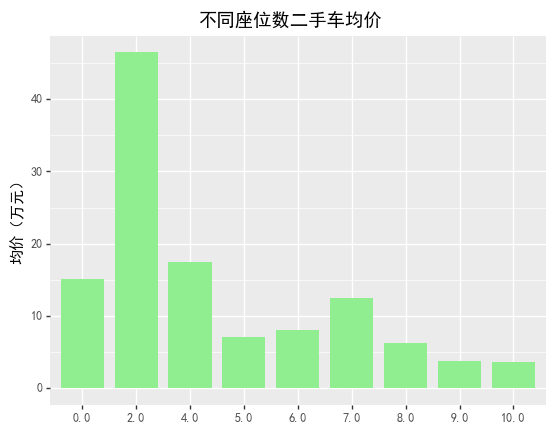

<ggplot: (120850864532)>

In [21]:
df10 = pd.DataFrame(df.groupby('Seats')['Price'].mean()).reset_index()
(
    ggplot(df10, aes('factor(Seats)', 'Price'))
    + geom_bar(stat='identity', width=0.8, size=0.25, alpha=1, fill='lightgreen')
    + xlab('')
    + ylab('均价（万元）')
    + ggtitle('不同座位数二手车均价')
    + theme(text=element_text(family=['SimHei']))
)

In [22]:
#建立训练集和测试集
X_d = df.iloc[:,:-1]
y_d = df.iloc[:,-1]
#提取训练数据及测试数据
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.15, random_state=1)

In [23]:
#定义评价指标函数，score即为R2
def evaluation(model):
    ypred = model.predict(X_test_d)
    mae = mean_absolute_error(y_test_d, ypred)
    mse = mean_squared_error(y_test_d, ypred)
    rmse = sqrt(mse)
    print("MAE: %.2f" % mae)
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)

In [24]:
#KNN模型进行预测
model_knn = KNeighborsRegressor()
model_knn.fit(X_train_d, y_train_d)
print("train score: ", model_knn.score(X_train_d, y_train_d))
print("test score: ", model_knn.score(X_test_d, y_test_d))
evaluation(model_knn)

train score:  0.7188882242943493
test score:  0.6054490456224464
MAE: 3.41
MSE: 36.78
RMSE: 6.06


In [25]:
#线性回归建模预测
model_LR = LinearRegression()
model_LR.fit(X_train_d, y_train_d)
print("train score: ", model_LR.score(X_train_d, y_train_d))
print("test score: ", model_LR.score(X_test_d, y_test_d))
evaluation(model_LR)

train score:  0.7113673397724563
test score:  0.7697245257080458
MAE: 2.96
MSE: 21.47
RMSE: 4.63


In [26]:
#决策树建模预测
model_dtr = DecisionTreeRegressor(max_depth = 5, random_state=30)
model_dtr.fit(X_train_d, y_train_d)
print("train score: ", model_dtr.score(X_train_d, y_train_d))
print("test score: ", model_dtr.score(X_test_d, y_test_d))
evaluation(model_dtr)

train score:  0.8735196796756327
test score:  0.821412052117704
MAE: 2.09
MSE: 16.65
RMSE: 4.08


In [27]:
#随机森林建模预测
model_rfr = RandomForestRegressor(random_state=1)
model_rfr.fit(X_train_d, y_train_d)
print("train score: ", model_rfr.score(X_train_d, y_train_d))
print("test score: ", model_rfr.score(X_test_d, y_test_d))
evaluation(model_rfr)

train score:  0.9832144599869291
test score:  0.9137331399356153
MAE: 1.30
MSE: 8.04
RMSE: 2.84


In [28]:
#定义二手车类
class UsedCars:
    def __init__(self, Name, Year, Kilometers_Driven, Fuel_Type, Transmission, Owner_Type, Mileage, Engine, Power, Seats):
        self.Name = Name
        self.Year = Year
        self.Kilometers_Driven = Kilometers_Driven
        self.Fuel_Type = Fuel_Type
        self.Transmission = Transmission
        self.Owner_Type = Owner_Type
        self.Mileage = Mileage
        self.Engine = Engine
        self.Power = Power
        self.Seats = Seats
    #定义预测函数
    def invoke(self):
        #解决二手车品牌输入错误异常
        try:
            df_name_dict[self.Name]
        except KeyError:
            return '二手车品牌错误'
        itest = []
        itest.append(float(df_name_dict[self.Name]))
        itest.append(float(self.Year))
        itest.append(float(self.Kilometers_Driven))
        itest.append(float(self.Fuel_Type))
        itest.append(float(self.Transmission))
        itest.append(float(self.Owner_Type))
        itest.append(float(self.Mileage))
        itest.append(float(self.Engine))
        itest.append(float(self.Power))
        itest.append(float(self.Seats))
        res_rfr = model_rfr.predict(np.array(itest).reshape(1, -1))[0]
        res_dtr = model_dtr.predict(np.array(itest).reshape(1, -1))[0]
        res_LR = model_LR.predict(np.array(itest).reshape(1, -1))[0]
        res_knn = model_knn.predict(np.array(itest).reshape(1, -1))[0]
        print('随机森林模型评估的该二手车价格为：'+str(round(res_rfr,4))+'万元人民币；\n'+\
               '决策树模型评估的该二手车价格为：'+str(round(res_dtr,4))+'万元人民币；\n'+\
               '线性回归模型评估的该二手车价格为：'+str(round(res_LR,4))+'万元人民币；\n'+\
               'KNN模型评估的该二手车价格为：'+str(round(res_knn,4))+'万元人民币。') 

In [29]:
car = UsedCars('Toyota',2013,70000,0,0,1,24,1400,100,5)
car.invoke()

随机森林模型评估的该二手车价格为：4.1039万元人民币；
决策树模型评估的该二手车价格为：3.4488万元人民币；
线性回归模型评估的该二手车价格为：7.4784万元人民币；
KNN模型评估的该二手车价格为：4.412万元人民币。


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names


In [30]:
car2 = UsedCars('Toyo',2013,70000,0,0,1,24,1400,100,5)   #输入错误品牌示例
car2.invoke()

'二手车品牌错误'